In [ ]:
 !pip install keras-tuner --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, top_k_accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [ ]:
# loading dataset from local google drive location
file_path = "/content/drive/MyDrive/SEP 769/Crop_recommendation.csv"
df = pd.read_csv(file_path)
display(df.head())

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
# Analyzing and exploring data using major funcitons like info() and describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


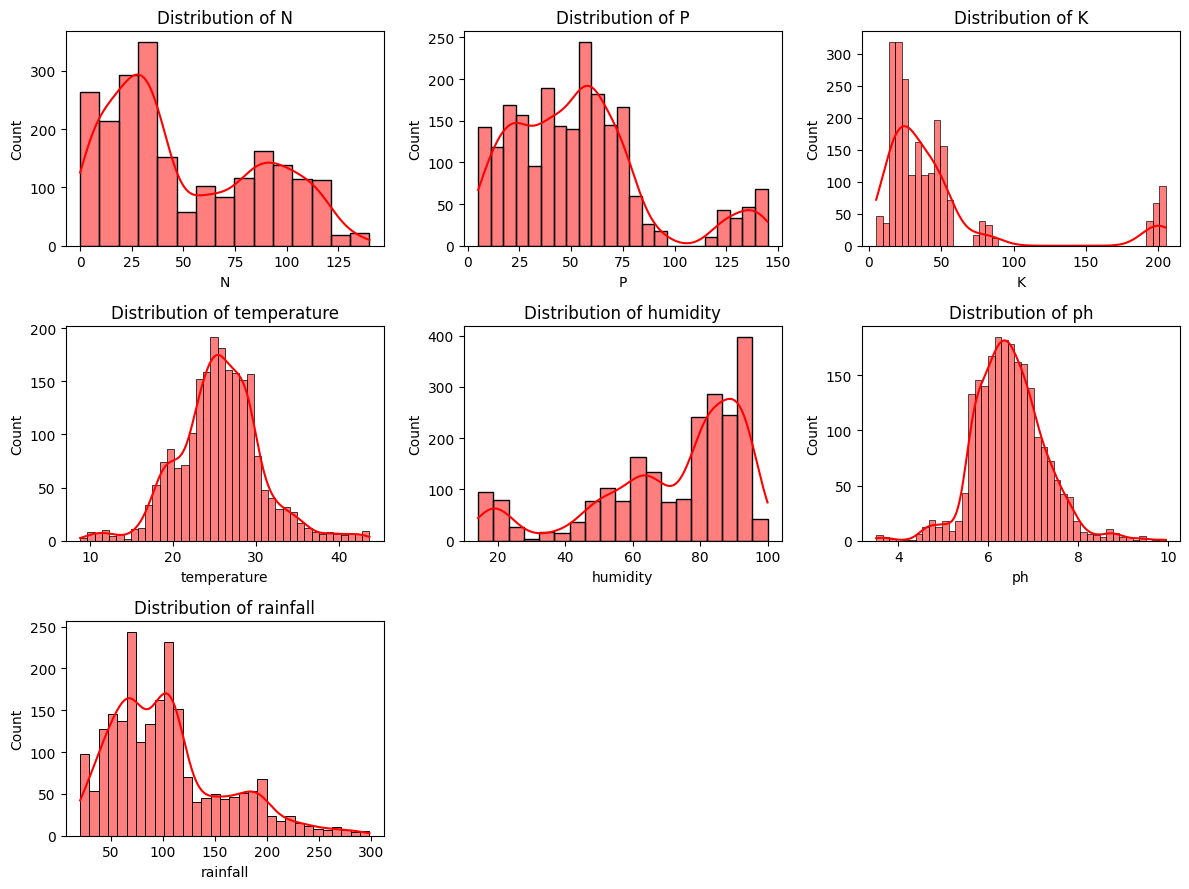

In [ ]:
# Drop label column
features = df.drop(columns='label')

# Determine the number of features
num_features = len(features.columns)

# Set up the number of rows and columns for subplots
cols = 3  # You can change this depending on how many plots per row you want
rows = (num_features + cols - 1) // cols  # Ceiling division

# Set the figure size
plt.figure(figsize=(cols * 4, rows * 3))

# Loop through each feature and plot
for idx, column in enumerate(features.columns):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(df[column], kde=True, color='red')
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()

### The presented graphs reveal that while the 'pH' distribution exhibits a unimodal, right-skewed pattern with a clear central tendency around 6.5, which is close to the neutral pH of 7, the remaining variables—'temperature,' 'humidity,' 'K,' 'rainfall,' 'N,' and 'P'—demonstrate varying degrees of multimodality. This suggests the underlying data for these parameters deviates from a simple normal distribution. The presence of multiple peaks, particularly pronounced in 'K' and 'P,' necessitates a more granular analysis, potentially involving mixture models or data segmentation, to accurately interpret the system's behavior

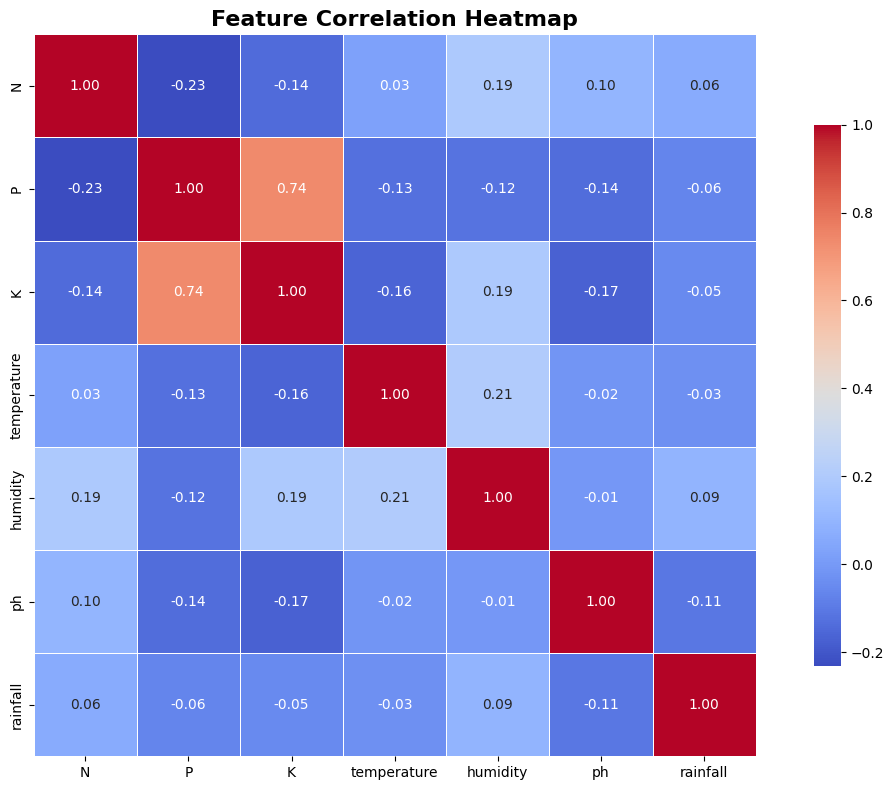

In [ ]:
# Calculate the correlation matrix
correlation_matrix = features.corr()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show correlation values
    fmt=".2f",          # Format to 2 decimal places
    cmap="coolwarm",    # Color map
    square=True,        # Square cells
    linewidths=0.5,     # Line between cells
    cbar_kws={"shrink": 0.75}  # Color bar size
)

# Title and layout
plt.title("Feature Correlation Heatmap", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Initialize a label encoder to convert categorical labels into numerical values
le = LabelEncoder()

# Fit the encoder on the 'label' column and transform it into a new column 'label_enc'
df['label_enc'] = le.fit_transform(df['label'])

# Determine the total number of unique classes for classification tasks
num_classes = len(le.classes_)

In [ ]:
# Convert the encoded labels into one-hot vectors for use in multi-class classification
Y = to_categorical(df['label_enc'])

In [ ]:
# Drop the original and encoded label columns to retain only feature columns
X = df.drop(columns=['label', 'label_enc'])

# Scale all feature values to the range [0, 1] to improve model performance
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train-Test Split 80:20
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Basic DNN (Deep Neural Network) — with 30 and 50 epochs versions

In [ ]:
# Build a basic Deep Neural Network (DNN) model for multi-class classification
def create_dnn_model(input_shape, num_classes):
    model = models.Sequential()

    # First hidden layer with 128 units and ReLU activation
    model.add(layers.Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(0.3))  # Dropout to reduce overfitting

    # Second hidden layer with 64 units
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Third hidden layer with 32 units
    model.add(layers.Dense(32, activation='relu'))

    # Output layer with softmax activation for multi-class probability distribution
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer and categorical cross-entropy loss
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

    return model

# Create and train the DNN model
dnn_model = create_dnn_model(X_train.shape[1], num_classes)
history_dnn = dnn_model.fit(X_train, y_train, epochs=30, batch_size=32,
                            validation_split=0.2, verbose=1)

# Evaluate model performance on the test set
loss, acc, top3_acc = dnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0727 - loss: 3.0800 - top_k_categorical_accuracy: 0.1798 - val_accuracy: 0.1506 - val_loss: 3.0039 - val_top_k_categorical_accuracy: 0.2955
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1310 - loss: 2.9734 - top_k_categorical_accuracy: 0.3095 - val_accuracy: 0.2273 - val_loss: 2.6679 - val_top_k_categorical_accuracy: 0.5511
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2295 - loss: 2.6141 - top_k_categorical_accuracy: 0.5006 - val_accuracy: 0.4545 - val_loss: 2.0610 - val_top_k_categorical_accuracy: 0.8097
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4099 - loss: 2.0168 - top_k_categorical_accuracy: 0.7368 - val_accuracy: 0.6307 - val_loss: 1.4381 - val_top_k_categorical_accuracy: 0.9403
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4539 - loss: 1.5455 - top_k_categorical_accuracy: 0.8595 - val_accuracy: 0.6903 - val_loss: 1.0888 - val_top_k_categori

In [ ]:
# Predict probabilities for the first 5 samples in the test set
preds = dnn_model.predict(X_test[:5])

# Get indices of the top-3 predicted classes for each sample (sorted in descending order)
top_3_indices = np.argsort(preds, axis=1)[:, -3:][:, ::-1]

# Decode and display the top-3 predicted class labels alongside the actual label
for i, row in enumerate(top_3_indices):
    print(f"Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))  # Convert indices to label names
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])  # True label
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'cotton']
Actual Crop: muskmelon
---
Sample 2:
Top-3 Predicted Crops: ['watermelon' 'muskmelon' 'cotton']
Actual Crop: watermelon
---
Sample 3:
Top-3 Predicted Crops: ['papaya' 'banana' 'blackgram']
Actual Crop: papaya
---
Sample 4:
Top-3 Predicted Crops: ['papaya' 'grapes' 'apple']
Actual Crop: papaya
---
Sample 5:
Top-3 Predicted Crops: ['apple' 'grapes' 'papaya']
Actual Crop: apple
---


In [ ]:
# Convert one-hot labels and predictions to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(dnn_model.predict(X_test), axis=1)

# Get classification report as a dictionary
dnn_model_report = classification_report(y_true, y_pred, output_dict=True)

# Print only the final metrics
print(f"Accuracy        : {dnn_model_report['accuracy']:.4f}")
print(f"Macro Precision : {dnn_model_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {dnn_model_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {dnn_model_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy        : 0.9318
Macro Precision : 0.9366
Macro Recall    : 0.9364
Macro F1-Score  : 0.9288


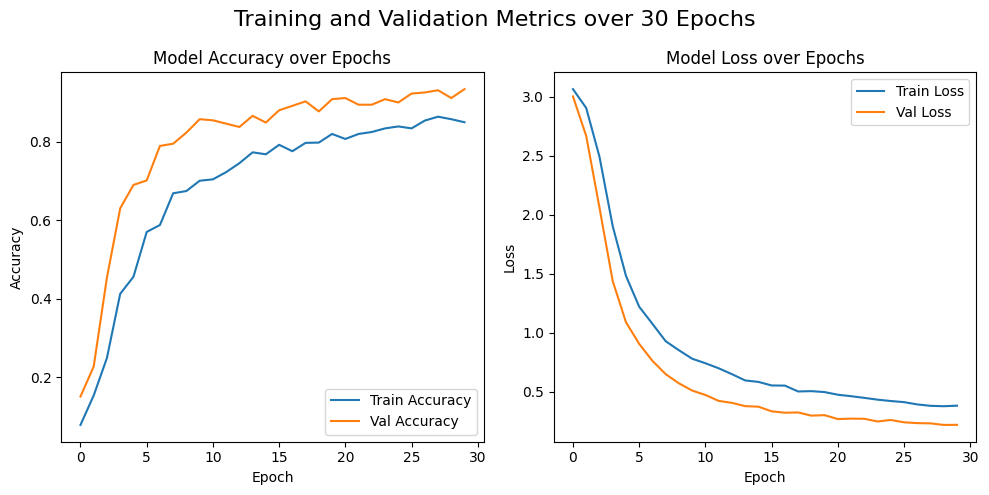

In [ ]:
plt.figure(figsize=(10, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Train Loss')
plt.plot(history_dnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Training and Validation Metrics over 30 Epochs', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Define a deeper DNN model architecture with mixed activation functions
def create_deep_dnn_model(input_dim, num_classes):
    model = Sequential()

    # Input layer with 512 units and tanh activation
    model.add(Dense(512, input_dim=input_dim, activation='tanh'))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Hidden layers with varying activations to enhance learning diversity
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='selu'))
    model.add(Dense(64, activation='relu'))

    # Output layer for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile with Adam optimizer and metrics including Top-3 accuracy
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_acc')])

    return model

# Create and train the deeper DNN model
dnn_model_50 = create_deep_dnn_model(X_train.shape[1], num_classes)

# Train the model for 50 epochs with a larger batch size
history_dnn_50 = dnn_model_50.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Evaluate model performance on the test set
loss, acc, top3_acc = dnn_model_50.evaluate(X_test, y_test, verbose=0)
print(f"[Deep DNN] Accuracy: {acc:.4f}, Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1075 - loss: 2.9693 - top_3_acc: 0.2608 - val_accuracy: 0.1818 - val_loss: 2.3697 - val_top_3_acc: 0.5199
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2938 - loss: 2.1802 - top_3_acc: 0.6355 - val_accuracy: 0.6392 - val_loss: 1.3601 - val_top_3_acc: 0.8977
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6113 - loss: 1.2503 - top_3_acc: 0.9196 - val_accuracy: 0.7443 - val_loss: 0.7568 - val_top_3_acc: 0.9886
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7460 - loss: 0.7541 - top_3_acc: 0.9786 - val_accuracy: 0.8438 - val_loss: 0.5384 - val_top_3_acc: 0.9943
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8158 - loss: 0.5705 - top_3_acc: 0.9904 - val_accuracy: 0.9290 - val_loss: 0.3367 - val_top_3_acc: 1.0000
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8833 - loss: 0.4038 - top_3_acc: 0.9959 - val_accuracy: 0.9091 - val_loss: 0.2972 - val_top_

In [ ]:
# use of same logic as above
preds = dnn_model_50.predict(X_test[:5])
top_3_indices = np.argsort(preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'papaya']
Actual Crop: muskmelon
---
Sample 2:
Top-3 Predicted Crops: ['watermelon' 'muskmelon' 'mango']
Actual Crop: watermelon
---
Sample 3:
Top-3 Predicted Crops: ['papaya' 'blackgram' 'banana']
Actual Crop: papaya
---
Sample 4:
Top-3 Predicted Crops: ['papaya' 'blackgram' 'banana']
Actual Crop: papaya
---
Sample 5:
Top-3 Predicted Crops: ['apple' 'papaya' 'banana']
Actual Crop: apple
---


In [ ]:
# Use of same logic as above
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(dnn_model_50.predict(X_test), axis=1)

dnn_model_50_report = classification_report(y_true, y_pred, output_dict=True)

print(f"Accuracy        : {dnn_model_50_report['accuracy']:.4f}")
print(f"Macro Precision : {dnn_model_50_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {dnn_model_50_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {dnn_model_50_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy        : 0.9477
Macro Precision : 0.9494
Macro Recall    : 0.9464
Macro F1-Score  : 0.9430


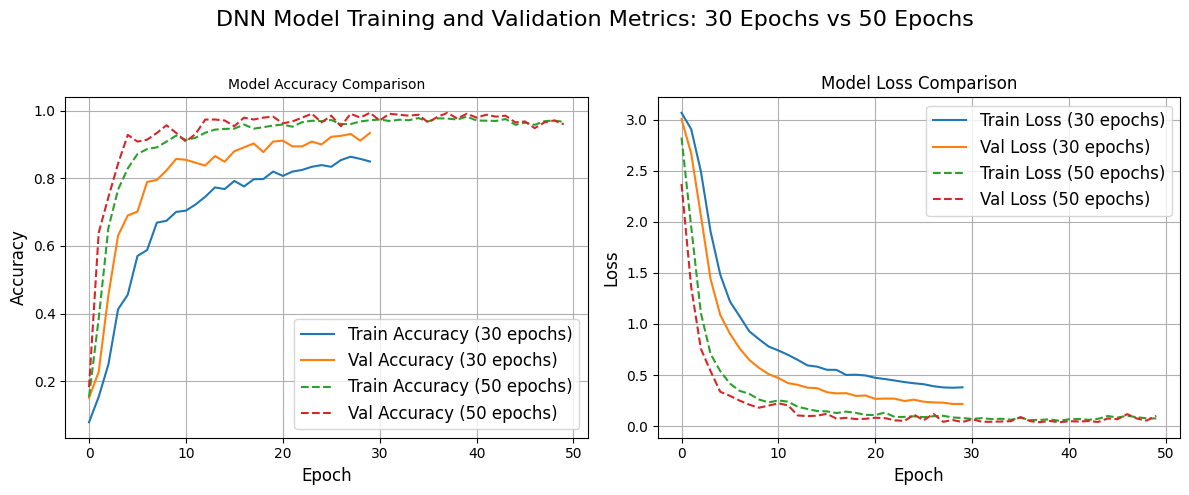

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Train Accuracy (30 epochs)')
plt.plot(history_dnn.history['val_accuracy'], label='Val Accuracy (30 epochs)')
plt.plot(history_dnn_50.history['accuracy'], label='Train Accuracy (50 epochs)', linestyle='--')
plt.plot(history_dnn_50.history['val_accuracy'], label='Val Accuracy (50 epochs)', linestyle='--')
plt.title('Model Accuracy Comparison', fontsize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Train Loss (30 epochs)')
plt.plot(history_dnn.history['val_loss'], label='Val Loss (30 epochs)')
plt.plot(history_dnn_50.history['loss'], label='Train Loss (50 epochs)', linestyle='--')
plt.plot(history_dnn_50.history['val_loss'], label='Val Loss (50 epochs)', linestyle='--')
plt.title('Model Loss Comparison', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('DNN Model Training and Validation Metrics: 30 Epochs vs 50 Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# CNN (Convolutional Neural Network) — with both 30 and a deeper CNN model trained for 50 epochs

In [ ]:
# Define a 1D Convolutional Neural Network for tabular feature input
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # First convolutional layer to extract local feature patterns
    model.add(layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))  # Downsample the feature maps

    # Second convolutional layer with reduced filters
    model.add(layers.Conv1D(32, kernel_size=2, activation='relu'))

    # Global pooling to reduce tensor dimensions and capture dominant features
    model.add(layers.GlobalMaxPooling1D())

    # Dense layer for high-level abstraction
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))  # Regularization

    # Output layer with softmax activation for class probabilities
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the CNN model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

    return model

# Reshape input features for compatibility with Conv1D layer
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and train the CNN model
cnn_model = create_cnn_model((X_train.shape[1], 1), num_classes)
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=30, batch_size=32,
                            validation_split=0.2, verbose=1)

# Evaluate model performance on reshaped test set
loss, acc, top3_acc = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN Test Accuracy: {acc:.4f}")
print(f"CNN Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0475 - loss: 3.0897 - top_k_categorical_accuracy: 0.1406 - val_accuracy: 0.0739 - val_loss: 3.0586 - val_top_k_categorical_accuracy: 0.2472
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1146 - loss: 3.0438 - top_k_categorical_accuracy: 0.2547 - val_accuracy: 0.1648 - val_loss: 2.9532 - val_top_k_categorical_accuracy: 0.4574
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2046 - loss: 2.8941 - top_k_categorical_accuracy: 0.4155 - val_accuracy: 0.2955 - val_loss: 2.6097 - val_top_k_categorical_accuracy: 0.5739
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2573 - loss: 2.5261 - top_k_categorical_accuracy: 0.5601 - val_accuracy: 0.4205 - val_loss: 2.0343 - val_top_k_categorical_accuracy: 0.7557
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3421 - loss: 2.0113 - top_k_categorical_accuracy: 0.6919 - val_accuracy: 0.5625 - val_loss: 1.5803 - val_top_k_categorical_accurac

In [ ]:
# Use of same logic as above
cnn_preds = cnn_model.predict(X_test_cnn[:5])
top_3_indices = np.argsort(cnn_preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"[CNN] Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[CNN] Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'mungbean']
Actual Crop: muskmelon
[CNN] Sample 2:
Top-3 Predicted Crops: ['watermelon' 'muskmelon' 'lentil']
Actual Crop: watermelon
[CNN] Sample 3:
Top-3 Predicted Crops: ['papaya' 'blackgram' 'mungbean']
Actual Crop: papaya
[CNN] Sample 4:
Top-3 Predicted Crops: ['papaya' 'mungbean' 'blackgram']
Actual Crop: papaya
[CNN] Sample 5:
Top-3 Predicted Crops: ['apple' 'grapes' 'papaya']
Actual Crop: apple


In [ ]:
# Reshape X_test for CNN (e.g., from (440, 7) to (440, 7, 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict and evaluate
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

cnn_model_report = classification_report(y_true, y_pred, output_dict=True)

# Print only the final metrics
print(f"Accuracy        : {cnn_model_report['accuracy']:.4f}")
print(f"Macro Precision : {cnn_model_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {cnn_model_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {cnn_model_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy        : 0.9136
Macro Precision : 0.9167
Macro Recall    : 0.9224
Macro F1-Score  : 0.9120


In [ ]:
# Define an enhanced CNN model with deeper architecture and ELU activations
def create_cnn_model_50(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  # Explicit input layer for clarity and best practices

    # First convolutional block with 128 filters and ELU activation
    model.add(layers.Conv1D(128, kernel_size=3, activation='elu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))  # Downsample the output

    # Second convolutional block with 64 filters
    model.add(layers.Conv1D(64, kernel_size=3, activation='elu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # Third convolutional layer without pooling to retain more spatial detail
    model.add(layers.Conv1D(32, kernel_size=2, activation='elu', padding='same'))

    # Global pooling to reduce dimensionality and prevent overfitting
    model.add(layers.GlobalMaxPooling1D())

    # Dense layer to combine extracted features
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dropout(0.4))  # Increased dropout rate for stronger regularization

    # Output layer for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with Adam optimizer and top-3 accuracy metric
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

    return model

# Reshape feature inputs to match the expected input shape of Conv1D layers
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and train the CNN model for 50 epochs
cnn_model_50 = create_cnn_model_50((X_train.shape[1], 1), num_classes)
history_cnn_50 = cnn_model_50.fit(X_train_cnn, y_train, epochs=50, batch_size=32,
                                  validation_split=0.2, verbose=1)

# Evaluate the trained model on the test set
loss, acc, top3_acc = cnn_model_50.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN Model (50 epochs) Test Accuracy: {acc:.4f}")
print(f"CNN Model (50 epochs) Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0821 - loss: 3.0375 - top_k_categorical_accuracy: 0.2265 - val_accuracy: 0.1705 - val_loss: 2.5668 - val_top_k_categorical_accuracy: 0.5938
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2396 - loss: 2.3096 - top_k_categorical_accuracy: 0.6021 - val_accuracy: 0.4688 - val_loss: 1.5439 - val_top_k_categorical_accuracy: 0.8438
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4332 - loss: 1.5520 - top_k_categorical_accuracy: 0.8240 - val_accuracy: 0.6733 - val_loss: 1.1098 - val_top_k_categorical_accuracy: 0.9716
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5261 - loss: 1.2008 - top_k_categorical_accuracy: 0.9235 - val_accuracy: 0.6875 - val_loss: 0.8866 - val_top_k_categorical_accuracy: 0.9574
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6238 - loss: 0.9359 - top_k_categorical_accuracy: 0.9669 - val_accuracy: 0.7784 - val_loss: 0.6063 - val_top_k_cate

In [ ]:
# use of same logic as above
cnn_preds = cnn_model_50.predict(X_test_cnn[:5])
top_3_indices = np.argsort(cnn_preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"[CNN] Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
[CNN] Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'cotton']
Actual Crop: muskmelon
[CNN] Sample 2:
Top-3 Predicted Crops: ['watermelon' 'muskmelon' 'grapes']
Actual Crop: watermelon
[CNN] Sample 3:
Top-3 Predicted Crops: ['papaya' 'blackgram' 'banana']
Actual Crop: papaya
[CNN] Sample 4:
Top-3 Predicted Crops: ['papaya' 'banana' 'blackgram']
Actual Crop: papaya
[CNN] Sample 5:
Top-3 Predicted Crops: ['apple' 'grapes' 'pigeonpeas']
Actual Crop: apple


In [ ]:
# Reshape X_test for CNN (e.g., from (440, 7) to (440, 7, 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict and evaluate
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(cnn_model_50.predict(X_test_cnn), axis=1)

cnn_model_50_report = classification_report(y_true, y_pred, output_dict=True)

# Print only the final metrics
print(f"Accuracy        : {cnn_model_50_report['accuracy']:.4f}")
print(f"Macro Precision : {cnn_model_50_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {cnn_model_50_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {cnn_model_50_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Accuracy        : 0.9682
Macro Precision : 0.9683
Macro Recall    : 0.9710
Macro F1-Score  : 0.9682


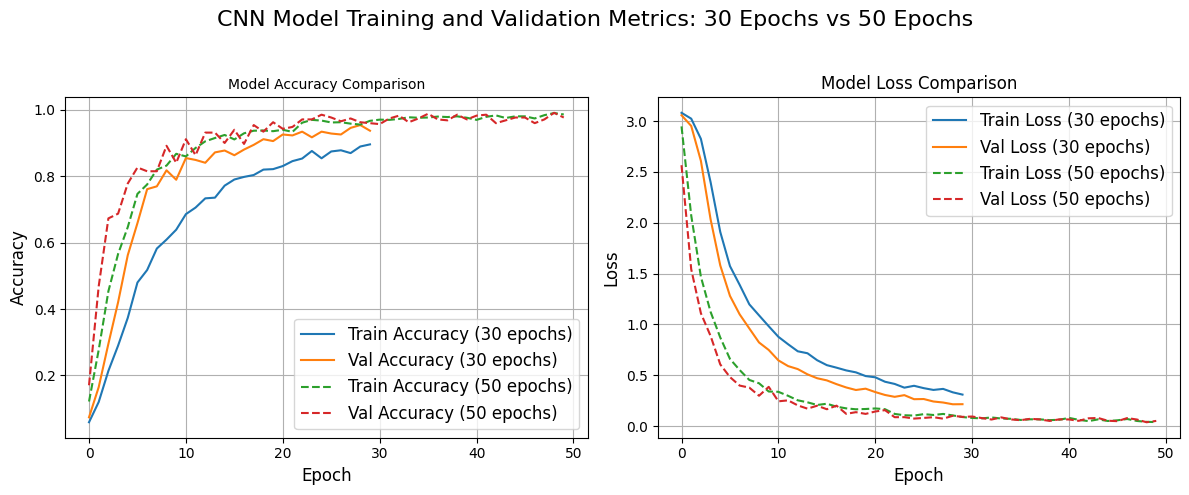

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy (30 epochs)')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy (30 epochs)')
plt.plot(history_cnn_50.history['accuracy'], label='Train Accuracy (50 epochs)', linestyle='--')
plt.plot(history_cnn_50.history['val_accuracy'], label='Val Accuracy (50 epochs)', linestyle='--')
plt.title('Model Accuracy Comparison', fontsize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss (30 epochs)')
plt.plot(history_cnn.history['val_loss'], label='Val Loss (30 epochs)')
plt.plot(history_cnn_50.history['loss'], label='Train Loss (50 epochs)', linestyle='--')
plt.plot(history_cnn_50.history['val_loss'], label='Val Loss (50 epochs)', linestyle='--')
plt.title('Model Loss Comparison', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('CNN Model Training and Validation Metrics: 30 Epochs vs 50 Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# RNN - LSTM (Long Short-Term Memory) — with both 30 and a deeper LSTM model trained for 50 epochs

In [ ]:
# Define an LSTM model for sequence modeling on feature data
def create_lstm_model(input_shape, num_classes):
    model = models.Sequential()

    # First LSTM layer returning sequences for stacking another LSTM layer
    model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))

    # Second LSTM layer that outputs the last time step
    model.add(layers.LSTM(32))

    # Dense layer for feature abstraction
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to reduce overfitting

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with Adam optimizer and top-3 accuracy metric
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
    return model


# Reshape input data to 3D tensor (samples, timesteps, features) for LSTM compatibility
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Instantiate and train the LSTM model
lstm_model = create_lstm_model((X_train.shape[1], 1), num_classes)
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=32,
                              validation_split=0.2, verbose=1)

# Evaluate the LSTM model on the test set
loss, acc, top3_acc = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"LSTM Test Accuracy: {acc:.4f}")
print(f"LSTM Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.0514 - loss: 3.0909 - top_k_categorical_accuracy: 0.1273 - val_accuracy: 0.0426 - val_loss: 3.0844 - val_top_k_categorical_accuracy: 0.1477
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0534 - loss: 3.0700 - top_k_categorical_accuracy: 0.1598 - val_accuracy: 0.0682 - val_loss: 2.8888 - val_top_k_categorical_accuracy: 0.2273
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0972 - loss: 2.8396 - top_k_categorical_accuracy: 0.2768 - val_accuracy: 0.1335 - val_loss: 2.4421 - val_top_k_categorical_accuracy: 0.3864
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1365 - loss: 2.4575 - top_k_categorical_accuracy: 0.3800 - val_accuracy: 0.1392 - val_loss: 2.2625 - val_top_k_categorical_accuracy: 0.5085
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1751 - loss: 2.2778 - top_k_categorical_accuracy: 0.4907 - val_accuracy: 0.2670 - val_loss: 2.0486 - val_top_k_categorical_acc

In [ ]:
# use of same logic as above
lstm_preds = lstm_model.predict(X_test_lstm[:5])
top_3_indices = np.argsort(lstm_preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"[LSTM] Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[LSTM] Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'jute']
Actual Crop: muskmelon
---
[LSTM] Sample 2:
Top-3 Predicted Crops: ['watermelon' 'rice' 'muskmelon']
Actual Crop: watermelon
---
[LSTM] Sample 3:
Top-3 Predicted Crops: ['papaya' 'apple' 'grapes']
Actual Crop: papaya
---
[LSTM] Sample 4:
Top-3 Predicted Crops: ['papaya' 'blackgram' 'mungbean']
Actual Crop: papaya
---
[LSTM] Sample 5:
Top-3 Predicted Crops: ['grapes' 'apple' 'banana']
Actual Crop: apple
---


In [ ]:
# Reshape X_test to match LSTM input shape
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict and evaluate
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)

lstm_model_report = classification_report(y_true, y_pred, output_dict=True)

# Print final metrics
print(f"Accuracy        : {lstm_model_report['accuracy']:.4f}")
print(f"Macro Precision : {lstm_model_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {lstm_model_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {lstm_model_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy        : 0.6364
Macro Precision : 0.6590
Macro Recall    : 0.6507
Macro F1-Score  : 0.6158


In [ ]:
# Define a deeper LSTM model with three stacked LSTM layers and ELU activation
def create_lstm_model_50(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  # Explicit input layer

    # Stack LSTM layers with return_sequences=True for intermediate layers
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32))  # Final LSTM layer outputs last time step

    # Dense layer with ELU activation for improved non-linearity
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dropout(0.3))  # Dropout for regularization

    # Output layer with softmax for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile model with Adam optimizer and top-3 accuracy metric
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
    return model

# Reshape data for LSTM input (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create and train the deeper LSTM model for 50 epochs
lstm_model_50 = create_lstm_model_50((X_train.shape[1], 1), num_classes)
history_lstm_50 = lstm_model_50.fit(X_train_lstm, y_train, epochs=50, batch_size=32,
                                    validation_split=0.2, verbose=1)

# Evaluate the model on the test dataset
loss, acc, top3_acc = lstm_model_50.evaluate(X_test_lstm, y_test, verbose=0)
print(f"LSTM Model (50 epochs) Test Accuracy: {acc:.4f}")
print(f"LSTM Model (50 epochs) Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.0557 - loss: 3.0875 - top_k_categorical_accuracy: 0.1449 - val_accuracy: 0.0625 - val_loss: 2.9454 - val_top_k_categorical_accuracy: 0.2443
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0934 - loss: 2.7961 - top_k_categorical_accuracy: 0.2736 - val_accuracy: 0.1136 - val_loss: 2.4854 - val_top_k_categorical_accuracy: 0.3352
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1203 - loss: 2.5035 - top_k_categorical_accuracy: 0.3482 - val_accuracy: 0.1761 - val_loss: 2.2931 - val_top_k_categorical_accuracy: 0.5000
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.1790 - loss: 2.2934 - top_k_categorical_accuracy: 0.4691 - val_accuracy: 0.2386 - val_loss: 1.9995 - val_top_k_categorical_accuracy: 0.5966
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2163 - loss: 2.0641 - top_k_categorical_accuracy: 0.5533 - val_accuracy: 0.2983 - val_loss: 1.8166 - val_top_k_cate

In [ ]:
# use of same logic as above
lstm_preds = lstm_model_50.predict(X_test_lstm[:5])
top_3_indices = np.argsort(lstm_preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"[LSTM] Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
[LSTM] Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'jute']
Actual Crop: muskmelon
---
[LSTM] Sample 2:
Top-3 Predicted Crops: ['watermelon' 'muskmelon' 'coffee']
Actual Crop: watermelon
---
[LSTM] Sample 3:
Top-3 Predicted Crops: ['papaya' 'muskmelon' 'apple']
Actual Crop: papaya
---
[LSTM] Sample 4:
Top-3 Predicted Crops: ['papaya' 'muskmelon' 'blackgram']
Actual Crop: papaya
---
[LSTM] Sample 5:
Top-3 Predicted Crops: ['grapes' 'apple' 'papaya']
Actual Crop: apple
---


In [ ]:
# Reshape X_test to match LSTM input shape
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Predict and evaluate
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(lstm_model_50.predict(X_test_lstm), axis=1)

lstm_model_50_report = classification_report(y_true, y_pred, output_dict=True)

# Print final metrics
print(f"Accuracy        : {lstm_model_50_report['accuracy']:.4f}")
print(f"Macro Precision : {lstm_model_50_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {lstm_model_50_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {lstm_model_50_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy        : 0.7409
Macro Precision : 0.7282
Macro Recall    : 0.7571
Macro F1-Score  : 0.7189


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


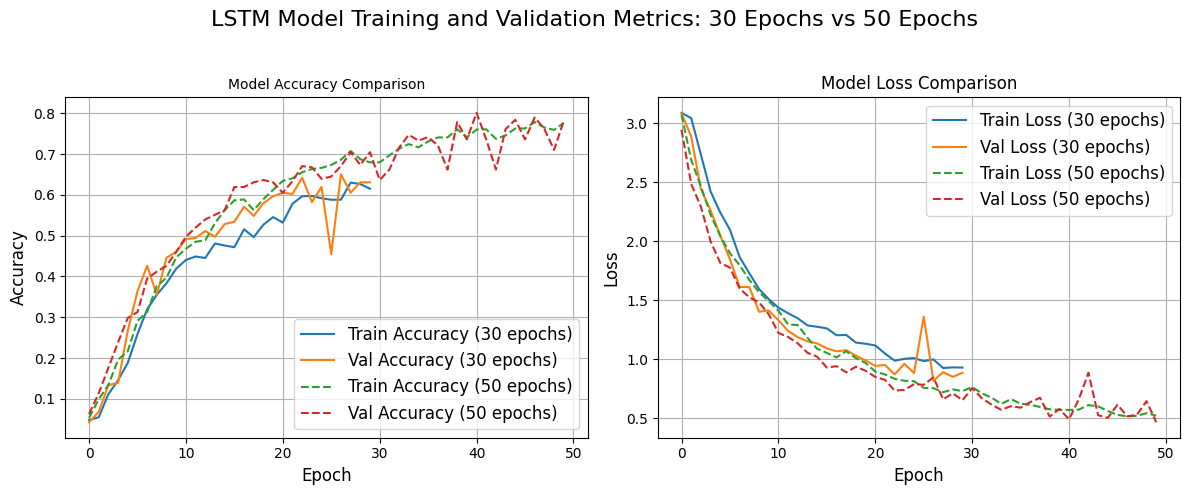

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy (30 epochs)')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy (30 epochs)')
plt.plot(history_lstm_50.history['accuracy'], label='Train Accuracy (50 epochs)', linestyle='--')
plt.plot(history_lstm_50.history['val_accuracy'], label='Val Accuracy (50 epochs)', linestyle='--')
plt.title('Model Accuracy Comparison', fontsize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss (30 epochs)')
plt.plot(history_lstm.history['val_loss'], label='Val Loss (30 epochs)')
plt.plot(history_lstm_50.history['loss'], label='Train Loss (50 epochs)', linestyle='--')
plt.plot(history_lstm_50.history['val_loss'], label='Val Loss (50 epochs)', linestyle='--')
plt.title('Model Loss Comparison', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('LSTM Model Training and Validation Metrics: 30 Epochs vs 50 Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# RNN - GRU (Gated Recurrent Unit) — with both 30 and a deeper GRU model trained for 50 epochs

In [ ]:
# Define a GRU model with two stacked GRU layers for sequential feature learning
def create_gru_model(input_shape, num_classes):
    model = models.Sequential()

    # First GRU layer with return_sequences=True to stack the next GRU layer
    model.add(layers.GRU(64, return_sequences=True, input_shape=input_shape))

    # Second GRU layer outputting the last time step
    model.add(layers.GRU(32))

    # Dense layer for feature extraction with ReLU activation
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer and top-3 accuracy metric
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
    return model

# Reshape input data to 3D tensor (samples, timesteps, features) for GRU layers
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create and train the GRU model
gru_model = create_gru_model((X_train.shape[1], 1), num_classes)
history_gru = gru_model.fit(X_train_gru, y_train, epochs=30, batch_size=32,
                            validation_split=0.2, verbose=1)

# Evaluate the GRU model performance on test data
loss, acc, top3_acc = gru_model.evaluate(X_test_gru, y_test, verbose=0)
print(f"GRU Test Accuracy: {acc:.4f}")
print(f"GRU Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0518 - loss: 3.0909 - top_k_categorical_accuracy: 0.1472 - val_accuracy: 0.0426 - val_loss: 3.0845 - val_top_k_categorical_accuracy: 0.1477
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0493 - loss: 3.0808 - top_k_categorical_accuracy: 0.1636 - val_accuracy: 0.1307 - val_loss: 3.0325 - val_top_k_categorical_accuracy: 0.1790
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0805 - loss: 2.9508 - top_k_categorical_accuracy: 0.2415 - val_accuracy: 0.1335 - val_loss: 2.5874 - val_top_k_categorical_accuracy: 0.4091
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1537 - loss: 2.5140 - top_k_categorical_accuracy: 0.3754 - val_accuracy: 0.2188 - val_loss: 2.1733 - val_top_k_categorical_accuracy: 0.5710
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2280 - loss: 2.2055 - top_k_categorical_accuracy: 0.5075 - val_accuracy: 0.3722 - val_loss: 1.9248 - val_top_k_categorical_acc

In [ ]:
# use of same logic as above
gru_preds = gru_model.predict(X_test_gru[:5])
top_3_indices = np.argsort(gru_preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"[GRU] Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
[GRU] Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'banana']
Actual Crop: muskmelon
---
[GRU] Sample 2:
Top-3 Predicted Crops: ['watermelon' 'muskmelon' 'blackgram']
Actual Crop: watermelon
---
[GRU] Sample 3:
Top-3 Predicted Crops: ['papaya' 'apple' 'grapes']
Actual Crop: papaya
---
[GRU] Sample 4:
Top-3 Predicted Crops: ['papaya' 'apple' 'orange']
Actual Crop: papaya
---
[GRU] Sample 5:
Top-3 Predicted Crops: ['apple' 'grapes' 'papaya']
Actual Crop: apple
---


In [ ]:
# use of same logic as above
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(gru_model.predict(X_test_lstm), axis=1)

gru_model_report = classification_report(y_true, y_pred, output_dict=True)

print(f"Accuracy        : {gru_model_report['accuracy']:.4f}")
print(f"Macro Precision : {gru_model_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {gru_model_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {gru_model_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy        : 0.8841
Macro Precision : 0.8851
Macro Recall    : 0.8806
Macro F1-Score  : 0.8771


In [ ]:
# Define a deeper GRU model with three stacked GRU layers and ELU activation
def create_gru_model_50(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  # Explicit input layer

    # Stack GRU layers with return_sequences=True except for the last layer
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.GRU(64, return_sequences=True))
    model.add(layers.GRU(32))  # Final GRU layer outputs last time step

    # Dense layer with ELU activation for nonlinear feature transformation
    model.add(layers.Dense(64, activation='elu'))
    model.add(layers.Dropout(0.3))  # Dropout for regularization

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile with Adam optimizer and top-3 accuracy metric
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
    return model

# Reshape input data to 3D tensor for GRU compatibility
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Create and train the deeper GRU model for 50 epochs
gru_model_50 = create_gru_model_50((X_train.shape[1], 1), num_classes)
history_gru_50 = gru_model_50.fit(X_train_gru, y_train, epochs=50, batch_size=32,
                                  validation_split=0.2, verbose=1)

# Evaluate model on test data
loss, acc, top3_acc = gru_model_50.evaluate(X_test_gru, y_test, verbose=0)
print(f"GRU Model (50 epochs) Test Accuracy: {acc:.4f}")
print(f"GRU Model (50 epochs) Top-3 Accuracy: {top3_acc:.4f}")

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.0486 - loss: 3.0884 - top_k_categorical_accuracy: 0.1446 - val_accuracy: 0.0682 - val_loss: 3.0504 - val_top_k_categorical_accuracy: 0.2074
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.0938 - loss: 2.9088 - top_k_categorical_accuracy: 0.2688 - val_accuracy: 0.1023 - val_loss: 2.4570 - val_top_k_categorical_accuracy: 0.3267
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1350 - loss: 2.4490 - top_k_categorical_accuracy: 0.4016 - val_accuracy: 0.2131 - val_loss: 2.1459 - val_top_k_categorical_accuracy: 0.5767
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2320 - loss: 2.1379 - top_k_categorical_accuracy: 0.5640 - val_accuracy: 0.4034 - val_loss: 1.7126 - val_top_k_categorical_accuracy: 0.7699
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3750 - loss: 1.7165 - top_k_categorical_accuracy: 0.7205 - val_accuracy: 0.4574 - val_loss: 1.4674 - val_top_k_cate

In [ ]:
# use of same logic as above
gru_preds = gru_model_50.predict(X_test_gru[:5])
top_3_indices = np.argsort(gru_preds, axis=1)[:, -3:][:, ::-1]

for i, row in enumerate(top_3_indices):
    print(f"[GRU] Sample {i+1}:")
    print("Top-3 Predicted Crops:", le.inverse_transform(row))
    print("Actual Crop:", le.inverse_transform([np.argmax(y_test[i])])[0])
    print("---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
[GRU] Sample 1:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'apple']
Actual Crop: muskmelon
---
[GRU] Sample 2:
Top-3 Predicted Crops: ['muskmelon' 'watermelon' 'apple']
Actual Crop: watermelon
---
[GRU] Sample 3:
Top-3 Predicted Crops: ['papaya' 'apple' 'mungbean']
Actual Crop: papaya
---
[GRU] Sample 4:
Top-3 Predicted Crops: ['papaya' 'apple' 'mungbean']
Actual Crop: papaya
---
[GRU] Sample 5:
Top-3 Predicted Crops: ['apple' 'grapes' 'papaya']
Actual Crop: apple
---


In [ ]:
# use of same logic as above
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(gru_model_50.predict(X_test_lstm), axis=1)

gru_model_50_report = classification_report(y_true, y_pred, output_dict=True)

print(f"Accuracy        : {gru_model_50_report['accuracy']:.4f}")
print(f"Macro Precision : {gru_model_50_report['macro avg']['precision']:.4f}")
print(f"Macro Recall    : {gru_model_50_report['macro avg']['recall']:.4f}")
print(f"Macro F1-Score  : {gru_model_50_report['macro avg']['f1-score']:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy        : 0.8750
Macro Precision : 0.8869
Macro Recall    : 0.8741
Macro F1-Score  : 0.8696


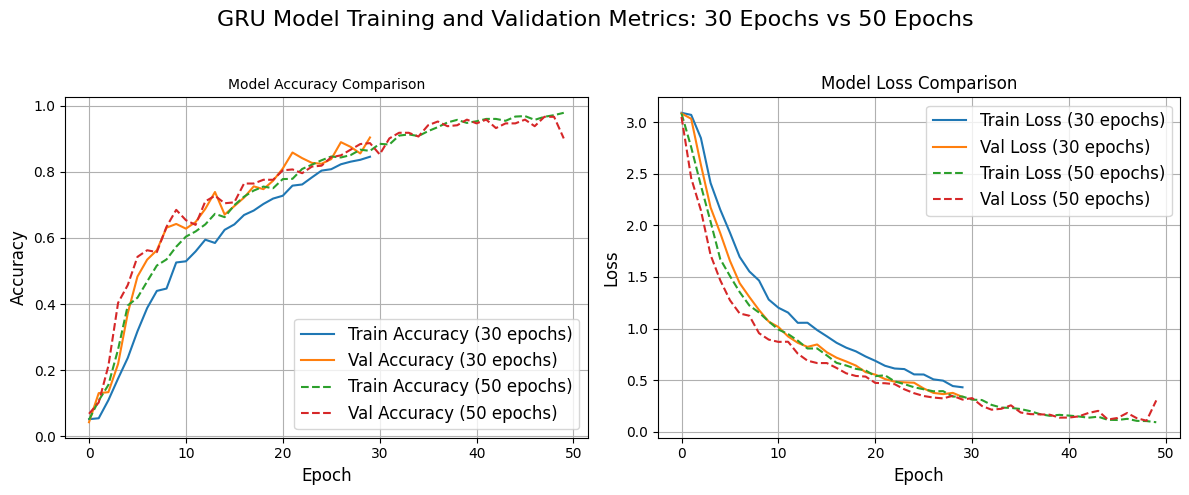

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy (30 epochs)')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy (30 epochs)')
plt.plot(history_gru_50.history['accuracy'], label='Train Accuracy (50 epochs)', linestyle='--')
plt.plot(history_gru_50.history['val_accuracy'], label='Val Accuracy (50 epochs)', linestyle='--')
plt.title('Model Accuracy Comparison', fontsize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (30 epochs)')
plt.plot(history_gru.history['val_loss'], label='Val Loss (30 epochs)')
plt.plot(history_gru_50.history['loss'], label='Train Loss (50 epochs)', linestyle='--')
plt.plot(history_gru_50.history['val_loss'], label='Val Loss (50 epochs)', linestyle='--')
plt.title('Model Loss Comparison', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.suptitle('GRU Model Training and Validation Metrics: 30 Epochs vs 50 Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
model_results_30 = {
    'Model': [
        'Basic DNN (30 epochs)', 'Basic DNN (50 epochs)',
        'CNN (30 epochs)', 'CNN (50 epochs)',
        'LSTM (30 epochs)', 'LSTM (50 epochs)',
        'GRU (30 epochs)', 'GRU (50 epochs)'
    ],

    'Accuracy': [
        history_dnn.history['val_accuracy'][-1],
        history_dnn_50.history['val_accuracy'][-1],
        history_cnn.history['val_accuracy'][-1],
        history_cnn_50.history['val_accuracy'][-1],
        history_lstm.history['val_accuracy'][-1],
        history_lstm_50.history['val_accuracy'][-1],
        history_gru.history['val_accuracy'][-1],
        history_gru_50.history['val_accuracy'][-1]
    ],

    'Macro Precision': [
        dnn_model_report['macro avg']['precision'],
        dnn_model_50_report['macro avg']['precision'],
        cnn_model_report['macro avg']['precision'],
        cnn_model_50_report['macro avg']['precision'],
        lstm_model_report['macro avg']['precision'],
        lstm_model_50_report['macro avg']['precision'],
        gru_model_report['macro avg']['precision'],
        gru_model_50_report['macro avg']['precision']
    ],

    'Macro Recall': [
        dnn_model_report['macro avg']['recall'],
        dnn_model_50_report['macro avg']['recall'],
        cnn_model_report['macro avg']['recall'],
        cnn_model_50_report['macro avg']['recall'],
        lstm_model_report['macro avg']['recall'],
        lstm_model_50_report['macro avg']['recall'],
        gru_model_report['macro avg']['recall'],
        gru_model_50_report['macro avg']['recall']
    ],

    'Macro F1-Score': [
        dnn_model_report['macro avg']['f1-score'],
        dnn_model_50_report['macro avg']['f1-score'],
        cnn_model_report['macro avg']['f1-score'],
        cnn_model_50_report['macro avg']['f1-score'],
        lstm_model_report['macro avg']['f1-score'],
        lstm_model_50_report['macro avg']['f1-score'],
        gru_model_report['macro avg']['f1-score'],
        gru_model_50_report['macro avg']['f1-score']
    ],

    'Top-3 Accuracy': [
        history_dnn.history['val_top_k_categorical_accuracy'][-1],
        history_dnn_50.history['val_top_3_acc'][-1],  # Custom name in your metric
        history_cnn.history['val_top_k_categorical_accuracy'][-1],
        history_cnn_50.history['val_top_k_categorical_accuracy'][-1],
        history_lstm.history['val_top_k_categorical_accuracy'][-1],
        history_lstm_50.history['val_top_k_categorical_accuracy'][-1],
        history_gru.history['val_top_k_categorical_accuracy'][-1],
        history_gru_50.history['val_top_k_categorical_accuracy'][-1]
    ]
}

# Create DataFrame
results = pd.DataFrame(model_results_30)

# Display
print("Comparison of All Models (30 vs 50 epochs):")
print(results.to_string(index=False))


Comparison of All Models (30 vs 50 epochs):
                Model  Accuracy  Macro Precision  Macro Recall  Macro F1-Score  Top-3 Accuracy
Basic DNN (30 epochs)  0.934659         0.936643      0.936442        0.928837        1.000000
Basic DNN (50 epochs)  0.960227         0.949351      0.946365        0.943029        1.000000
      CNN (30 epochs)  0.937500         0.916687      0.922444        0.911992        1.000000
      CNN (50 epochs)  0.977273         0.968307      0.971015        0.968181        1.000000
     LSTM (30 epochs)  0.630682         0.658966      0.650715        0.615819        0.934659
     LSTM (50 epochs)  0.781250         0.728247      0.757128        0.718876        0.991477
      GRU (30 epochs)  0.903409         0.885057      0.880567        0.877136        0.994318
      GRU (50 epochs)  0.900568         0.886888      0.874089        0.869572        0.991477


In [ ]:
from tabulate import tabulate

# Tabulate table
print("\nComparison of All Models (30 vs 50 epochs):\n")
print(tabulate(results, headers='keys', tablefmt='fancy_grid', showindex=False, floatfmt=".4f"))


Comparison of All Models (30 vs 50 epochs):

╒═══════════════════════╤════════════╤═══════════════════╤════════════════╤══════════════════╤══════════════════╕
│ Model                 │   Accuracy │   Macro Precision │   Macro Recall │   Macro F1-Score │   Top-3 Accuracy │
╞═══════════════════════╪════════════╪═══════════════════╪════════════════╪══════════════════╪══════════════════╡
│ Basic DNN (30 epochs) │     0.9347 │            0.9366 │         0.9364 │           0.9288 │           1.0000 │
├───────────────────────┼────────────┼───────────────────┼────────────────┼──────────────────┼──────────────────┤
│ Basic DNN (50 epochs) │     0.9602 │            0.9494 │         0.9464 │           0.9430 │           1.0000 │
├───────────────────────┼────────────┼───────────────────┼────────────────┼──────────────────┼──────────────────┤
│ CNN (30 epochs)       │     0.9375 │            0.9167 │         0.9224 │           0.9120 │           1.0000 │
├───────────────────────┼────────────┼────

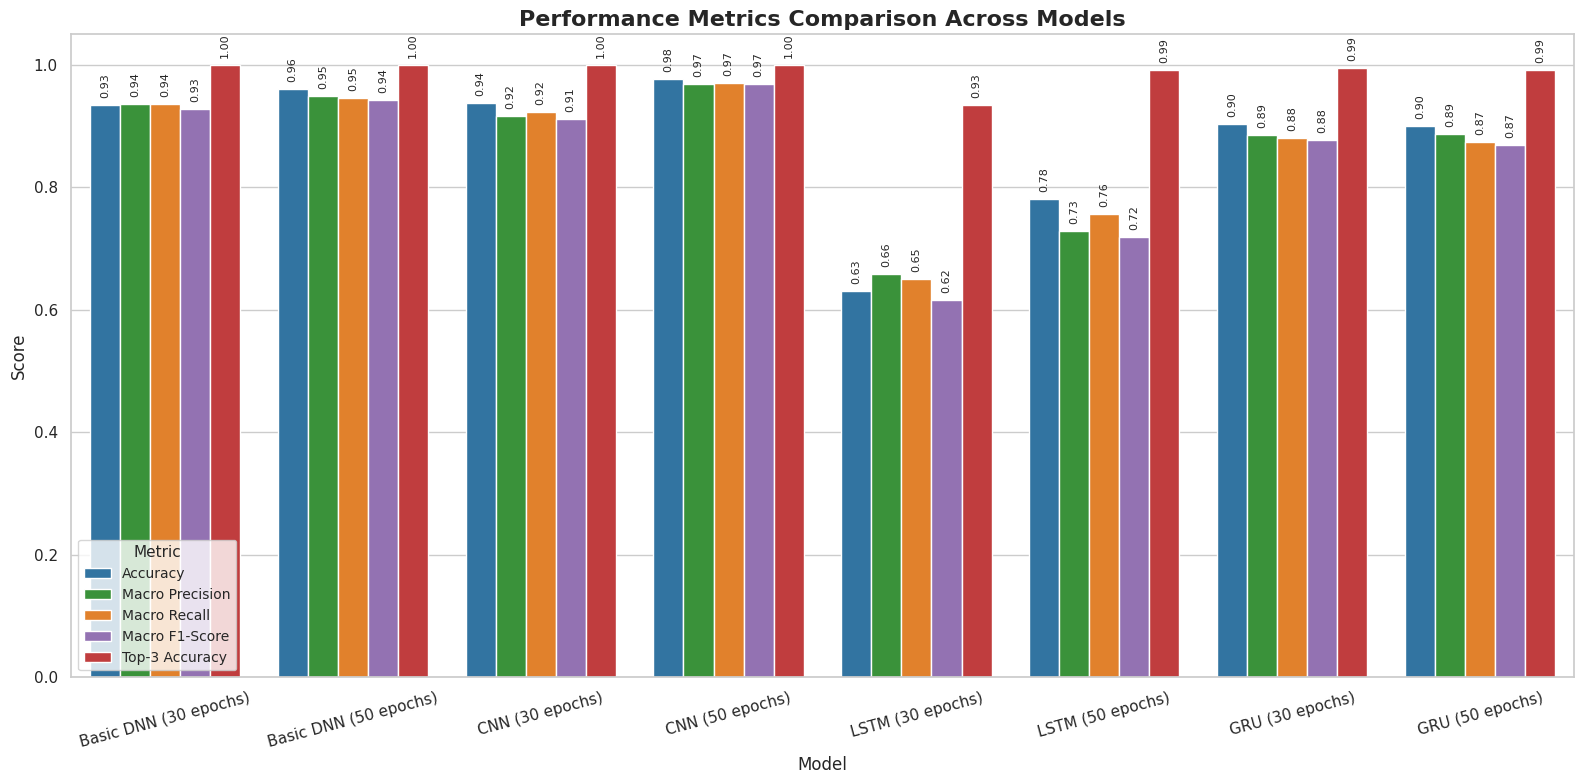

In [ ]:
# Reshape the DataFrame for grouped barplot
metrics_to_plot = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Top-3 Accuracy']
df_melted = results.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

sns.set(style="whitegrid", context="notebook")
palette = {
    'Accuracy': '#1f77b4',
    'Macro Precision': '#2ca02c',
    'Macro Recall': '#ff7f0e',
    'Macro F1-Score': '#9467bd',
    'Top-3 Accuracy': '#d62728'
}

plt.figure(figsize=(16, 8))  # Increased width
barplot = sns.barplot(
    data=df_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette=palette
)

# Add value labels rotated 90 degrees
for container in barplot.containers:
    barplot.bar_label(
        container,
        fmt='%.2f',
        label_type='edge',
        fontsize=8,
        rotation=90,
        padding=5  # Increased padding for spacing
    )

# Title and formatting
plt.title('Performance Metrics Comparison Across Models', fontsize=16, weight='bold')
plt.ylim(0, 1.05)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.legend(title='Metric', title_fontsize=11, fontsize=10)
plt.tight_layout()

plt.show()

In [ ]:

# Normalize all metric columns (assuming higher is better for all)
metric_columns = ['Accuracy', 'Macro F1-Score', 'Macro Precision', 'Macro Recall']
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(results[metric_columns])

# Compute composite score (mean of normalized metrics)
results['Composite Score'] = normalized_metrics.mean(axis=1)

# Find the best model based on all metrics
best_model_idx = results['Composite Score'].idxmax()
best_model = results.loc[best_model_idx]

print("Best Model considering all parameters:")
print(best_model)

Best Model considering all parameters:
Model              CNN (50 epochs)
Accuracy                  0.977273
Macro Precision           0.968307
Macro Recall              0.971015
Macro F1-Score            0.968181
Top-3 Accuracy                 1.0
Composite Score                1.0
Name: 3, dtype: object


/tmp/ipython-input-3039124483.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette="Blues_d")


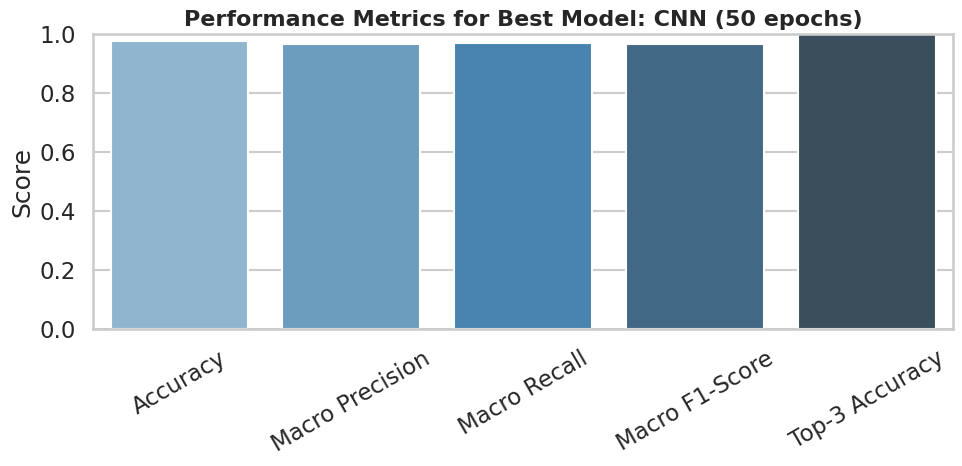

In [ ]:
# Prepare data for plotting (metrics and their values)
metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Top-3 Accuracy']
scores = best_model[metrics].values

# Plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 5))

sns.barplot(x=metrics, y=scores, palette="Blues_d")

plt.title(f"Performance Metrics for Best Model: {best_model['Model']}", fontsize=16, weight='bold')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
# Set the best model and its training history (Basic DNN 50 epochs)
best_model = cnn_model_50
best_history = history_cnn_50

print("X_test shape:", X_test.shape)
print("Model input shape:", best_model.input_shape)

X_test shape: (440, 7)
Model input shape: (None, 7, 1)


### From above analysis we concluded that dnn model with 50 epoch outperforms other model. So after this point we just focus on further evaluating the model.

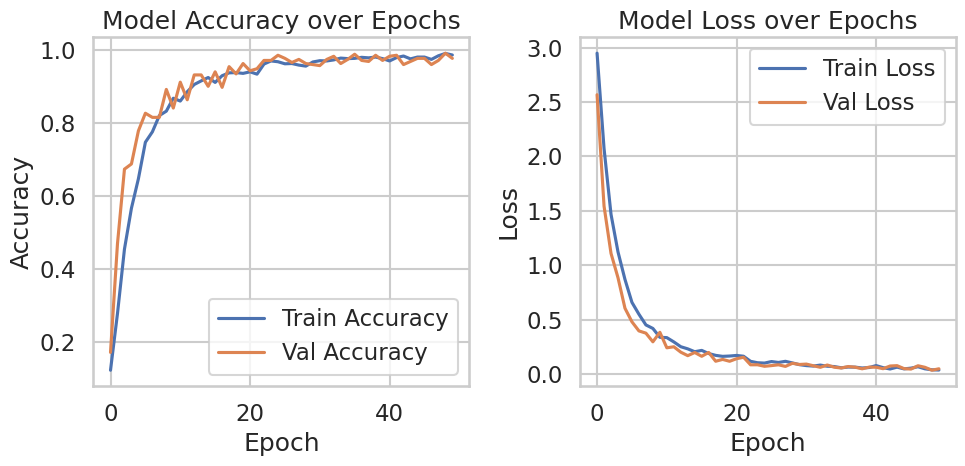

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
classes = [f"Class {i}" for i in range(7)]

In [ ]:
print("Expected model input shape:", best_model.input_shape)
print("Current X_test shape:", X_test.shape)

Expected model input shape: (None, 7, 1)
Current X_test shape: (440, 7)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


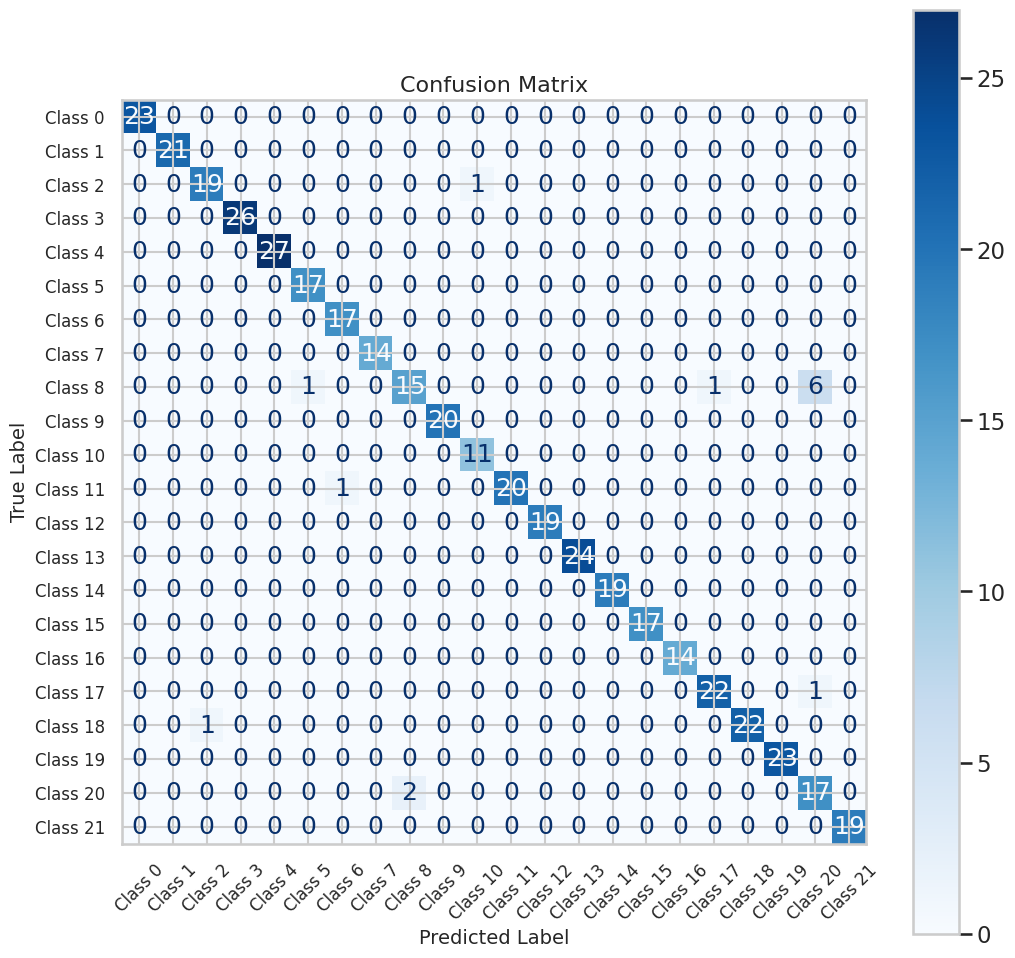

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
if len(best_model.input_shape) == 3:
    # For CNN or RNN: reshape to (samples, timesteps/features, channels)
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = best_model.predict(X_test_reshaped)
else:
    # For DNN: no reshaping
    y_pred = best_model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Proceed with confusion matrix generation as before
cm = confusion_matrix(y_true, y_pred_classes)
class_names = [f"Class {i}" for i in range(cm.shape[0])]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
# Extract the final training accuracy from the training history
train_acc = best_history.history['accuracy'][-1]

# Extract the final validation accuracy from the training history
val_acc = best_history.history['val_accuracy'][-1]

# Calculate the generalization gap (difference between training and validation accuracy)
gen_gap = train_acc - val_acc

# Calculate the Testaccuracy from the training history
test_acc = accuracy_score(y_true, y_pred_classes)

# Display the accuracies and generalization gap
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Generalization Gap: {gen_gap:.4f}")

Train Accuracy: 0.9865
Test Accuracy: 0.9682
Validation Accuracy: 0.9773
Generalization Gap: 0.0092


In [ ]:
# Define model creation function (same as before)
def create_deep_dnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='selu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_acc')]
    )
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_accuracies = []
val_top3_accuracies = []

# Create one model instance
input_dim = X_scaled.shape[1]
num_classes = Y.shape[1]
model = create_deep_dnn_model(input_dim, num_classes)

# Save initial weights for resetting later
initial_weights = model.get_weights()

for train_idx, val_idx in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = Y[train_idx], Y[val_idx]

    # Reset model weights to initial random state before training on new fold
    model.set_weights(initial_weights)

    # Train silently for 50 epochs
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, verbose=0)

    # Evaluate validation fold
    loss, acc, top3_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    val_accuracies.append(acc)
    val_top3_accuracies.append(top3_acc)

print(f"Cross-validated Accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
print(f"Cross-validated Top-3 Accuracy: {np.mean(val_top3_accuracies):.4f} ± {np.std(val_top3_accuracies):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-validated Accuracy: 0.9800 ± 0.0036
Cross-validated Top-3 Accuracy: 1.0000 ± 0.0000


In [ ]:
def predict_crop(user_input, model, crop_names=None):
    """
    Predict crop class given input features using the trained CNN model.

    Parameters:
    - user_input: list or array of 7 numerical features
    - model: the trained keras model for prediction
    - crop_names: (optional) list of crop names corresponding to class indices

    Returns:
    - predicted_class: integer index of predicted class
    - predicted_crop_name: name of predicted class if crop_names given, else None
    - probabilities: prediction probabilities array
    """
    # Validate input length
    if len(user_input) != 7:
        raise ValueError("Input must contain exactly 7 features.")

    # Prepare input for Conv1D model: reshape to (1, 7, 1)
    input_array = np.array(user_input, dtype=np.float32).reshape(1, 7, 1)

    # Predict probabilities
    probabilities = model.predict(input_array)[0]  # shape (num_classes,)

    # Get predicted class index
    predicted_class = np.argmax(probabilities)

    # Map to crop name if available
    predicted_crop_name = None
    if crop_names is not None:
        if predicted_class < len(crop_names):
            predicted_crop_name = crop_names[predicted_class]
        else:
            predicted_crop_name = "Unknown class"

    return predicted_class, predicted_crop_name, probabilities

In [ ]:
def predict_top3_crops(user_input, model, crop_names=None):
    """
    Predict top 3 crop classes for a 7-feature input using the trained CNN model.
    Returns:
    - top3_indices: list of top 3 class indices
    - top3_crop_names: list of top 3 crop names (if crop_names provided)
    - top3_probabilities: list of top 3 probabilities in percentage
    """
    if len(user_input) != 7:
        raise ValueError("Input must contain exactly 7 features.")

    # Reshape for Conv1D model: (1, 7, 1)
    input_array = np.array(user_input, dtype=np.float32).reshape(1, 7, 1)

    # Predict probabilities
    probabilities = model.predict(input_array)[0]  # shape: (num_classes,)

    # Get top 3 indices (sorted by probability descending)
    top3_indices = probabilities.argsort()[-3:][::-1]
    top3_probabilities = probabilities[top3_indices]

    # Map to crop names if available
    top3_crop_names = None
    if crop_names is not None:
        top3_crop_names = [crop_names[i] for i in top3_indices]

    return top3_indices.tolist(), top3_crop_names, (top3_probabilities * 100).round(2).tolist()

In [ ]:
crop_names = df['label'].unique().tolist()
print(crop_names)
len(crop_names)

['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate', 'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee']


22

In [ ]:
# User Test 1

user_input = [
    7,    # Feature 1: (e.g., Soil pH)
    1.0,  # Feature 2: (e.g., Temperature in °C)
    3,    # Feature 3: (e.g., Rainfall in mm)
    0,    # Feature 4: (e.g., Humidity %)
    1.0,  # Feature 5: (e.g., Nitrogen content)
    1.0,  # Feature 6: (e.g., Phosphorus content)
    2.1   # Feature 7: (e.g., Potassium content)
]

# List of crop names in correct order
crop_names = df['label'].unique().tolist()


predicted_class, predicted_crop_name, probs = predict_crop(user_input, best_model, crop_names)

print(f"Predicted crop name: {predicted_crop_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted crop name: mungbean


In [ ]:
# User Test 1

user_input = [
    7,    # Feature 1: (e.g., Soil pH)
    1.0,  # Feature 2: (e.g., Temperature in °C)
    3,    # Feature 3: (e.g., Rainfall in mm)
    0,    # Feature 4: (e.g., Humidity %)
    1.0,  # Feature 5: (e.g., Nitrogen content)
    1.0,  # Feature 6: (e.g., Phosphorus content)
    2.1   # Feature 7: (e.g., Potassium content)
]

# List of crop names in correct order
crop_names = df['label'].unique().tolist()


top3_indices, top3_names, top3_probs = predict_top3_crops(user_input,best_model, crop_names)

print("Top 3 crops:", top3_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Top 3 crops: ['mungbean', 'blackgram', 'maize']


In [ ]:
# User Test 2
user_input = [
    1,    # Feature 1: (e.g., Soil pH)
    1.0,  # Feature 2: (e.g., Temperature in °C)
    3,    # Feature 3: (e.g., Rainfall in mm)
    3,    # Feature 4: (e.g., Humidity %)
    3.0,  # Feature 5: (e.g., Nitrogen content)
    1.0,  # Feature 6: (e.g., Phosphorus content)
    2.1   # Feature 7: (e.g., Potassium content)
]

# List of crop names in correct order
crop_names = df['label'].unique().tolist()


predicted_class, predicted_crop_name, probs = predict_crop(user_input, best_model, crop_names)

print(f"Predicted crop name: {predicted_crop_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted crop name: papaya


In [ ]:
# User Test 2
user_input = [
    1,    # Feature 1: (e.g., Soil pH)
    1.0,  # Feature 2: (e.g., Temperature in °C)
    3,    # Feature 3: (e.g., Rainfall in mm)
    3,    # Feature 4: (e.g., Humidity %)
    3.0,  # Feature 5: (e.g., Nitrogen content)
    1.0,  # Feature 6: (e.g., Phosphorus content)
    2.1   # Feature 7: (e.g., Potassium content)
]


# List of crop names in correct order
crop_names = df['label'].unique().tolist()


top3_indices, top3_names, top3_probs = predict_top3_crops(user_input,best_model, crop_names)

print("Top 3 crops:", top3_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top 3 crops: ['papaya', 'blackgram', 'rice']


In [ ]:
# User Test 3
user_input = [
    5,    # Feature 1: (e.g., Soil pH)
    8.0,  # Feature 2: (e.g., Temperature in °C)
    3,    # Feature 3: (e.g., Rainfall in mm)
    10,   # Feature 4: (e.g., Humidity %)
    1.5,  # Feature 5: (e.g., Nitrogen content)
    1.0,  # Feature 6: (e.g., Phosphorus content)
    1.1   # Feature 7: (e.g., Potassium content)
]

# List of crop names in correct order
crop_names = df['label'].unique().tolist()


predicted_class, predicted_crop_name, probs = predict_crop(user_input, best_model, crop_names)

print(f"Predicted crop name: {predicted_crop_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted crop name: blackgram


In [ ]:
# User Test 3
user_input = [
    5,    # Feature 1: (e.g., Soil pH)
    8.0,  # Feature 2: (e.g., Temperature in °C)
    3,    # Feature 3: (e.g., Rainfall in mm)
    10,   # Feature 4: (e.g., Humidity %)
    1.5,  # Feature 5: (e.g., Nitrogen content)
    1.0,  # Feature 6: (e.g., Phosphorus content)
    1.1   # Feature 7: (e.g., Potassium content)
]

# List of crop names in correct order
crop_names = df['label'].unique().tolist()


top3_indices, top3_names, top3_probs = predict_top3_crops(user_input,best_model, crop_names)

print("Top 3 crops:", top3_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Top 3 crops: ['blackgram', 'maize', 'apple']


In [ ]:
# Save model
best_model.save('best_model.h5')

In [ ]:
# Load model later
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model.h5')


In [ ]:
# Evaluate the loaded model on the test dataset with detailed output
loss, acc, top3_acc = loaded_model.evaluate(X_test_cnn, y_test, verbose=1)

# Print the evaluation metrics: accuracy, top-3 accuracy, and loss
print(f"Loaded model - Accuracy: {acc:.4f}, Top-3 Accuracy: {top3_acc:.4f}, Loss: {loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9643 - loss: 0.0812 - top_k_categorical_accuracy: 1.0000
Loaded model - Accuracy: 0.9682, Top-3 Accuracy: 1.0000, Loss: 0.0741


In [ ]:
user_input = [
    1,    # Feature 1: (e.g., Soil pH)
    8.0,  # Feature 2: (e.g., Temperature in °C)
    50,    # Feature 3: (e.g., Rainfall in mm)
    10,   # Feature 4: (e.g., Humidity %)
    1.8,  # Feature 5: (e.g., Nitrogen content)
    0.1,  # Feature 6: (e.g., Phosphorus content)
    2.1   # Feature 7: (e.g., Potassium content)
]

# List of crop names in correct order
crop_names = df['label'].unique().tolist()


predicted_class, predicted_crop_name, probs = predict_crop(user_input, loaded_model, crop_names)

print(f"Predicted crop name: {predicted_crop_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Predicted crop name: apple


In [ ]:
user_input = [
    1,    # Feature 1: (e.g., Soil pH)
    8.0,  # Feature 2: (e.g., Temperature in °C)
    50,    # Feature 3: (e.g., Rainfall in mm)
    10,   # Feature 4: (e.g., Humidity %)
    1.8,  # Feature 5: (e.g., Nitrogen content)
    0.1,  # Feature 6: (e.g., Phosphorus content)
    2.1   # Feature 7: (e.g., Potassium content)
]
top3_indices, top3_names, top3_probs = predict_top3_crops(user_input, model, crop_names)
print("Top 3 crops:", top3_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Top 3 crops: ['blackgram', 'rice', 'papaya']
